In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import and Clean Data

In [2]:
def import_and_clean_data(return_df):
    
    if return_df == 'Data_public':
        
        # Import pre-cleaned data
        df1 = pd.read_stata('./replication_data/Data/Data_public.dta')

        # Process in the same way the authors do
        df1['_const']  = 1.0
        df1['agec']    = ((df1.age*3).astype(int)/3)+(1/(2*3))
        df1            = df1.sort_values('agec')
        df1['id0']     = df1.groupby('agec')['agec'].cumcount()+1
        df1['lwage0']  = np.log(df1.monthly_wage_0.replace(0, np.nan))
        df1['lwagen0'] = np.log(df1.monthly_wage_n0.replace(0, np.nan))

        # Fig1 vars
        df1['tot']    = df1.shape[0] 
        df1['ngroup'] = df1.groupby('agec')['agec'].transform(lambda x: x.count())
        df1['nec']    = df1.ngroup / df1.tot
        df1['lwage0_mean'] = df1.groupby('agec')['lwage0'].transform(lambda x: x[x != np.nan].mean())
        
        # Fig3 vars
        df1['ay1'] = np.where(df1.ned < 2*365, df1.ned, np.nan)
        df1['ay3'] = np.where(df1.ned < 39*7, 1, 0)
        df1['ay4'] = np.where(df1.ned < 2*365, df1.wg_c, np.nan)
        df1['ay6'] = np.where((df1.ned < 2*365) & (df1.wv == 1) & \
                               ~(df1.lwagen0.isnull()) & ~(df1.lwage0.isnull()), 
                              np.where(df1.lwagen0 > df1.lwage0+np.log(0.5), 1., 0.), 
                              np.nan)
        df1['ay1_mean'] = df1.groupby('agec')['ay1'].transform(lambda x: x[x != np.nan].mean())
        df1['ay3_mean'] = df1.groupby('agec')['ay3'].transform(lambda x: x[x != np.nan].mean())
        df1['ay4_mean'] = df1.groupby('agec')['ay4'].transform(lambda x: x[x != np.nan].mean())
        df1['ay6_mean'] = df1.groupby('agec')['ay6'].transform(lambda x: x[x != np.nan].mean())
        
        # Table 2 vars that haven't yet been created
        df1['ay2']    = np.where(df1.ned < 30*7, 1, 0)
        df1['ay5']    = np.where((df1.ned < 2*365) & (df1.wv == 1), df1.lwagen0, np.nan)
        df1['age40']  = np.where(df1.age>=40, 1, 0)
        df1['age_p1'] = df1.age**1
        df1['age_p2'] = df1.age**2
        df1['age_q1'] = ((df1.age-40.)**1)*df1.age40
        df1['age_q2'] = ((df1.age-40.)**2)*df1.age40

        return df1
    
    elif return_df == 'Data_public_pre_reform':
        
        # Import pre-cleaned data
        df2 = pd.read_stata('./replication_data/Data/Data_public_pre_reform.dta')

        # Process in the same way the authors do
        df2['_const'] = 1.0
        df2['agec']   = ((df2.age*3).astype(int)/3)+(1/(2*3))
        df2           = df2.sort_values('agec')
        df2['id0']    = df2.groupby('agec')['agec'].cumcount()+1

        # Fig2, Panel A and B vars
        df2['ay1'] = np.where(df2.ned < 2*365, df2.ned, np.nan)
        df2['ay4'] = np.where(df2.ned < 2*365, df2.wg_c, np.nan)
        df2['ay1_mean'] = df2.groupby('agec')['ay1'].transform(lambda x: x[x != np.nan].mean())
        df2['ay4_mean'] = df2.groupby('agec')['ay4'].transform(lambda x: x[x != np.nan].mean())
        
        return df2

In [3]:
df1 = import_and_clean_data('Data_public')
df2 = import_and_clean_data('Data_public_pre_reform')

# Q5(a) - Replication of Figures 1, 2, and 3

In [4]:
def get_qfit(df, x, y, qrange):
    
    # Create squared variable
    pltdf       = df[~(df[x].isnull() | df[y].isnull())].copy()
    pltdf['x2'] = (pltdf[x])**2

    # Do quadratic linear regression
    X    = pltdf[['_const',x,'x2']].to_numpy()
    Y    = pltdf[y].to_numpy()[:,None]
    beta = np.linalg.inv(X.T @ X) @ X.T @ Y

    # Get predictions
    qrange2 = qrange**2
    Xpred   = np.concatenate((np.ones((qrange.shape[0],1)), 
                              qrange[:,None], 
                              (qrange**2)[:,None]), 
                             axis=1)
    return (Xpred @ beta).ravel()

In [5]:
linspace_low  = np.linspace(30.,39.9,100)
linspace_high = np.linspace(40.1,50.,100)

## Figure 1 Replication

In [6]:
# Get quadratic fits for graphing
pltdf       = df1[df1.id0==1].copy()
qfit_low_a  = get_qfit(pltdf[pltdf.age <  40], 'agec', 'nec', linspace_low)
qfit_high_a = get_qfit(pltdf[pltdf.age >  40], 'agec', 'nec', linspace_high)
qfit_low_b  = get_qfit(df1[df1.age <  40], 'age', 'lwage0', linspace_low)
qfit_high_b = get_qfit(df1[df1.age >= 40], 'age', 'lwage0', linspace_high)

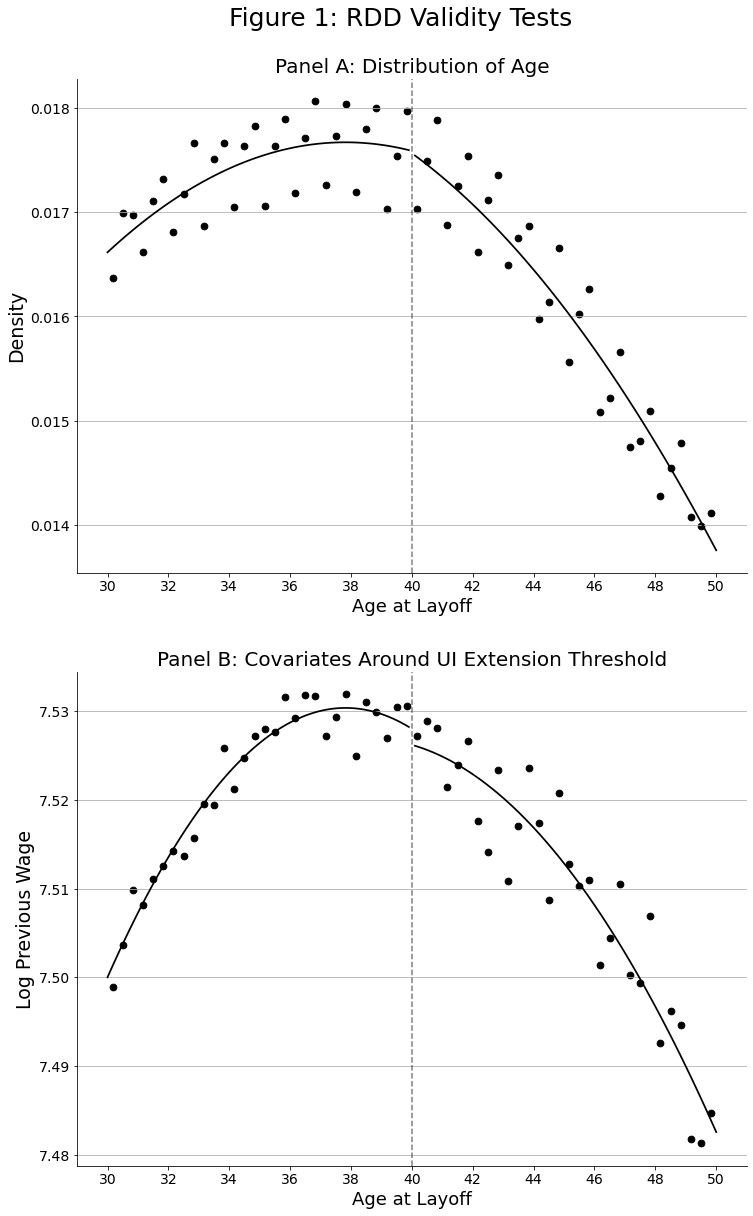

In [7]:
# Formatting stuff
fig,ax = plt.subplots(2, 1, figsize=(12,20))
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

# Do plotting
ax[0].scatter(pltdf.agec, pltdf.nec, color='black', s=45)
ax[0].plot(linspace_low, qfit_low_a, color='black', linewidth=1.75)
ax[0].plot(linspace_high, qfit_high_a, color='black', linewidth=1.75)
ax[0].axvline(x=40., linestyle='dashed', color='black', alpha=0.5)

ax[1].scatter(pltdf.agec, pltdf.lwage0_mean, color='black', s=45)
ax[1].plot(linspace_low, qfit_low_b, color='black', linewidth=1.75)
ax[1].plot(linspace_high, qfit_high_b, color='black', linewidth=1.75)
ax[1].axvline(x=40., linestyle='dashed', color='black', alpha=0.5)

# Axis formatting
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[0].set_xticks(np.arange(30.,51.,2.))
ax[1].set_xticks(np.arange(30.,51.,2.))
ax[0].set_xlabel("Age at Layoff", size=18)
ax[1].set_xlabel("Age at Layoff", size=18)
ax[0].set_ylabel("Density", size=19)
ax[1].set_ylabel("Log Previous Wage", size=19)
ax[0].grid(axis='y')
ax[1].grid(axis='y')

# Deal with titles
ax[0].set_title(f"Panel A: Distribution of Age", size=20)
ax[1].set_title(f"Panel B: Covariates Around UI Extension Threshold", size=20)
plt.suptitle("Figure 1: RDD Validity Tests", size=25, y=0.93)

# Save and show
plt.savefig(f"./q5_output/q5_fig1_rep.png")
plt.show()

## Figure 2 Replication

In [8]:
# Get quadratic fits for graphing
pltdf       = df2[df2.id0==1].copy()
qfit_low_a  = get_qfit(df2[df2.age <  40], 'age', 'ay1', linspace_low)
qfit_high_a = get_qfit(df2[df2.age >= 40], 'age', 'ay1', linspace_high)
qfit_low_b  = get_qfit(df2[df2.age <  40], 'age', 'ay4', linspace_low)
qfit_high_b = get_qfit(df2[df2.age >= 40], 'age', 'ay4', linspace_high)

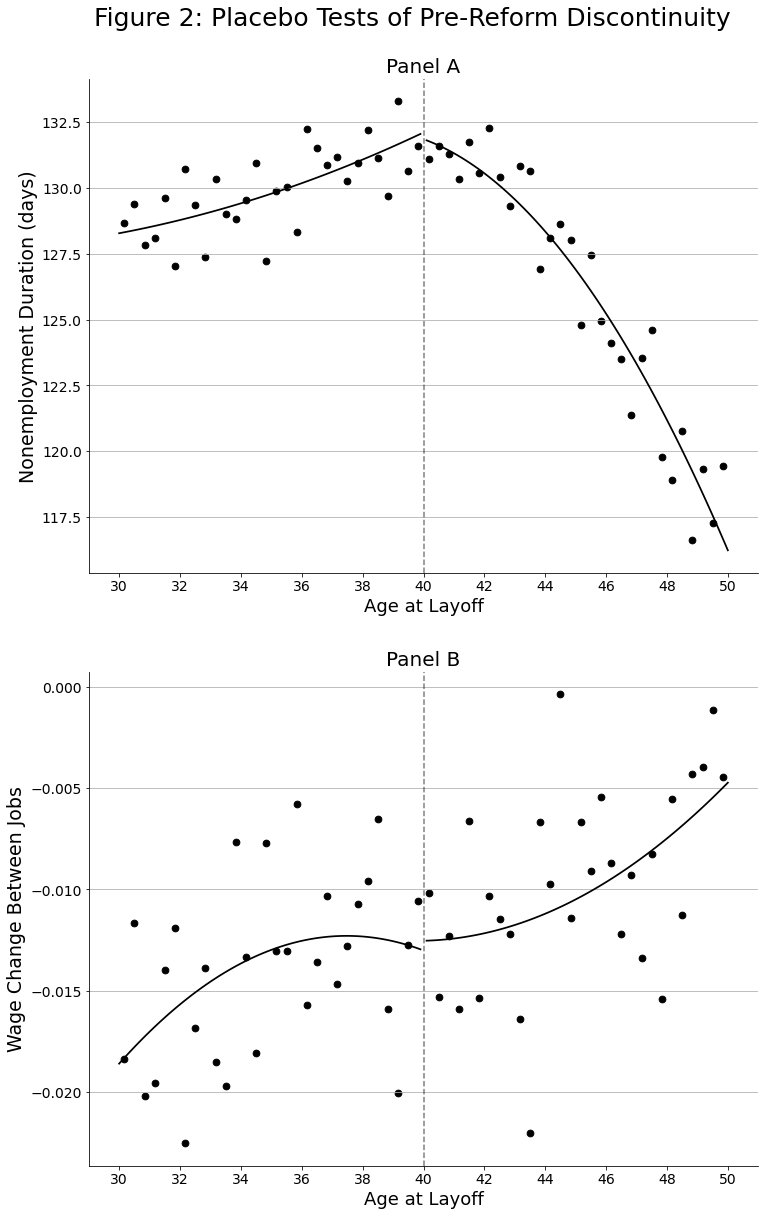

In [9]:
# Formatting stuff
fig,ax = plt.subplots(2, 1, figsize=(12,20))
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

# Do plotting
ax[0].scatter(pltdf.agec, pltdf.ay1_mean, color='black', s=45)
ax[0].plot(linspace_low, qfit_low_a, color='black', linewidth=1.75)
ax[0].plot(linspace_high, qfit_high_a, color='black', linewidth=1.75)
ax[0].axvline(x=40., linestyle='dashed', color='black', alpha=0.5)

ax[1].scatter(pltdf.agec, pltdf.ay4_mean, color='black', s=45)
ax[1].plot(linspace_low, qfit_low_b, color='black', linewidth=1.75)
ax[1].plot(linspace_high, qfit_high_b, color='black', linewidth=1.75)
ax[1].axvline(x=40., linestyle='dashed', color='black', alpha=0.5)

# Axis formatting
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[0].set_xticks(np.arange(30.,51.,2.))
ax[1].set_xticks(np.arange(30.,51.,2.))
ax[0].set_xlabel("Age at Layoff", size=18)
ax[1].set_xlabel("Age at Layoff", size=18)
ax[0].set_ylabel("Nonemployment Duration (days)", size=19)
ax[1].set_ylabel("Wage Change Between Jobs", size=19)
ax[0].grid(axis='y')
ax[1].grid(axis='y')

# Deal with titles
ax[0].set_title(f"Panel A", size=20)
ax[1].set_title(f"Panel B", size=20)
plt.suptitle("Figure 2: Placebo Tests of Pre-Reform Discontinuity", size=25, y=0.93)

# Save and show
plt.savefig(f"./q5_output/q5_fig2_rep.png")
plt.show()

## Figure 3 Replication

In [10]:
# Get quadratic fits for graphing
pltdf       = df1[df1.id0==1].copy()
qfit_low_a  = get_qfit(df1[df1.age <  40], 'age', 'ay1', linspace_low)
qfit_high_a = get_qfit(df1[df1.age >= 40], 'age', 'ay1', linspace_high)
qfit_low_b  = get_qfit(df1[df1.age <  40], 'age', 'ay3', linspace_low)
qfit_high_b = get_qfit(df1[df1.age >= 40], 'age', 'ay3', linspace_high)
qfit_low_c  = get_qfit(df1[df1.age <  40], 'age', 'ay4', linspace_low)
qfit_high_c = get_qfit(df1[df1.age >= 40], 'age', 'ay4', linspace_high)
qfit_low_d  = get_qfit(df1[df1.age <  40], 'age', 'ay6', linspace_low)
qfit_high_d = get_qfit(df1[df1.age >= 40], 'age', 'ay6', linspace_high)

qfit_low  = [qfit_low_a, qfit_low_b, qfit_low_c, qfit_low_d]
qfit_high = [qfit_high_a, qfit_high_b, qfit_high_c, qfit_high_d]

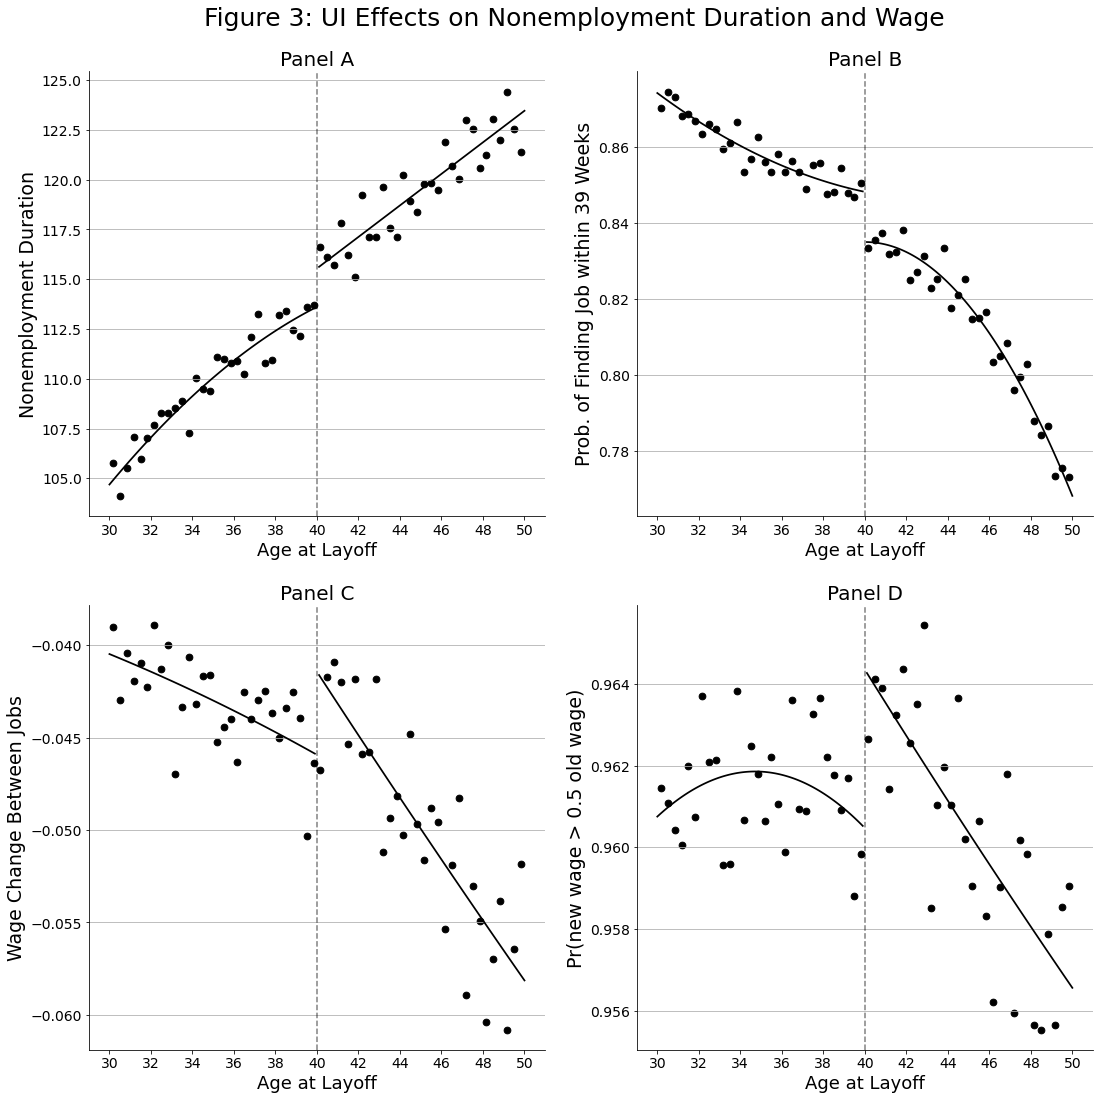

In [11]:
# Formatting stuff
fig,ax = plt.subplots(2, 2, figsize=(18,18))
ax     = ax.flatten()
for i in range(4):
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)

# Do plotting
for i in range(4):
    ax[i].plot(linspace_low, qfit_low[i], color='black', linewidth=1.75)
    ax[i].plot(linspace_high, qfit_high[i], color='black', linewidth=1.75)
    ax[i].axvline(x=40., linestyle='dashed', color='black', alpha=0.5)
ax[0].scatter(pltdf.agec, pltdf.ay1_mean, color='black', s=45)
ax[1].scatter(pltdf.agec, pltdf.ay3_mean, color='black', s=45)
ax[2].scatter(pltdf.agec, pltdf.ay4_mean, color='black', s=45)
ax[3].scatter(pltdf.agec, pltdf.ay6_mean, color='black', s=45)

# Axis formatting
for i in range(4):
    ax[i].tick_params(axis='both', which='major', labelsize=14)
    ax[i].set_xticks(np.arange(30.,51.,2.))
    ax[i].set_xlabel("Age at Layoff", size=18)
    ax[i].grid(axis='y')
ax[0].set_ylabel("Nonemployment Duration", size=19)
ax[1].set_ylabel("Prob. of Finding Job within 39 Weeks", size=19)
ax[2].set_ylabel("Wage Change Between Jobs", size=19)
ax[3].set_ylabel("Pr(new wage > 0.5 old wage)", size=19)

# Deal with titles
for i,let in enumerate(['A','B','C','D']):
    ax[i].set_title(f"Panel {let}", size=20)
plt.suptitle("Figure 3: UI Effects on Nonemployment Duration and Wage", size=25, y=0.93)

# Save and show
plt.savefig(f"./q5_output/q5_fig3_rep.png")
plt.show()

# Q5(b) - Replication Table 2

In [12]:
def run_rdd_regression(df, xvars, yvar):
    
    # Remove those with missing data
    pltdf = df[~(df[yvar].isnull())].copy()
    for xvar in xvars:
        pltdf = pltdf[~(pltdf[xvar].isnull())]

    # Form matrices and do regression
    X    = pltdf[xvars].to_numpy()
    Y    = pltdf[yvar].to_numpy()[:,None]
    beta = np.linalg.inv(X.T @ X) @ X.T @ Y

    # Get standard errors
    u2 = np.mean((Y - X @ beta)**2)
    beta_SE = np.sqrt(np.diag(u2*np.linalg.inv(X.T @ X)))
    
    return beta.ravel(),beta_SE,X.shape[0]

In [13]:
# Controls used in regressions
xvars = ['age40','age_p1','age_p2','age_q1','age_q2','_const']

# Loop across outcome variables to build table
betas        = []
beta_SEs     = []
cutoff_means = []
Ns           = []
for i in range(1,6+1):
    b, b_SE, N  = run_rdd_regression(df1, xvars=xvars, yvar=f'ay{i}')
    cutoff_mean = df1[abs(df1.age-40)<3][f'ay{i}'].mean()
    betas.append(b[0])
    beta_SEs.append(b_SE[0])
    cutoff_means.append(cutoff_mean)
    Ns.append(N)

In [15]:
# Format for table
depvars = ['Nonemployment duration (1)','Find job within 30 weeks (2)','Find job within 39 weeks (3)',
           'Wage change between jobs (4)','Log re-employment wage (5)','New wage > UI benefit (6)']
df = pd.DataFrame({'Dependent Variable':depvars,
                   'Estimate for Discontinuity at 40':np.round(betas,5),
                   '':['('+str(np.round(x,5))+')' for x in beta_SEs],
                   'Mean of Dep. Var. Around Cutoff':np.round(cutoff_means,3),
                   'Observations':['{:,}'.format(n) for n in Ns]})
df = df.transpose()
df.to_latex(f"./q5_output/q5_table2_rep.tex", header=False)
df

,0,1,2,3,4,5
Dependent Variable,Nonemployment duration (1),Find job within 30 weeks (2),Find job within 39 weeks (3),Wage change between jobs (4),Log re-employment wage (5),New wage > UI benefit (6)
Estimate for Discontinuity at 40,1.93207,-0.00973,-0.01318,0.00449,0.0035,0.00388
,(0.52552),(0.00178),(0.00165),(0.0017),(0.00234),(0.00105)
Mean of Dep. Var. Around Cutoff,114.663,0.805,0.842,-0.044,7.468,0.962
Observations,"1,589,178","1,738,787","1,738,787","1,187,476","1,189,446","1,187,476"


# Q5(d) - Evaluate Sensitivity to Cutoff for Column 2

In [16]:
bandwidths = np.linspace(0.2, 10., 100)

### Linear Specification

In [17]:
# Controls used in regressions
xvars = ['age40','age_p1','age_q1','_const']

# Loop over bandwidths
linear_betas    = []
linear_beta_upper_CI = []
linear_beta_lower_CI = []
for bandwidth in bandwidths:
    b,b_SE,_ = run_rdd_regression(df1[abs(df1.age-40) < bandwidth], xvars=xvars, yvar='ay2')
    linear_betas.append(b[0])
    linear_beta_upper_CI.append(b[0]+1.959*b_SE[0])
    linear_beta_lower_CI.append(b[0]-1.959*b_SE[0])

### Quadratic specification

In [18]:
# Controls used in regressions
xvars = ['age40','age_p1','age_p2','age_q1','age_q2','_const']

# Loop over bandwidths
quadratic_betas    = []
quadratic_beta_upper_CI = []
quadratic_beta_lower_CI = []
for bandwidth in bandwidths:
    b,b_SE,_ = run_rdd_regression(df1[abs(df1.age-40) < bandwidth], xvars=xvars, yvar='ay2')
    quadratic_betas.append(b[0])
    quadratic_beta_upper_CI.append(b[0]+1.959*b_SE[0])
    quadratic_beta_lower_CI.append(b[0]-1.959*b_SE[0])

### Plot Results

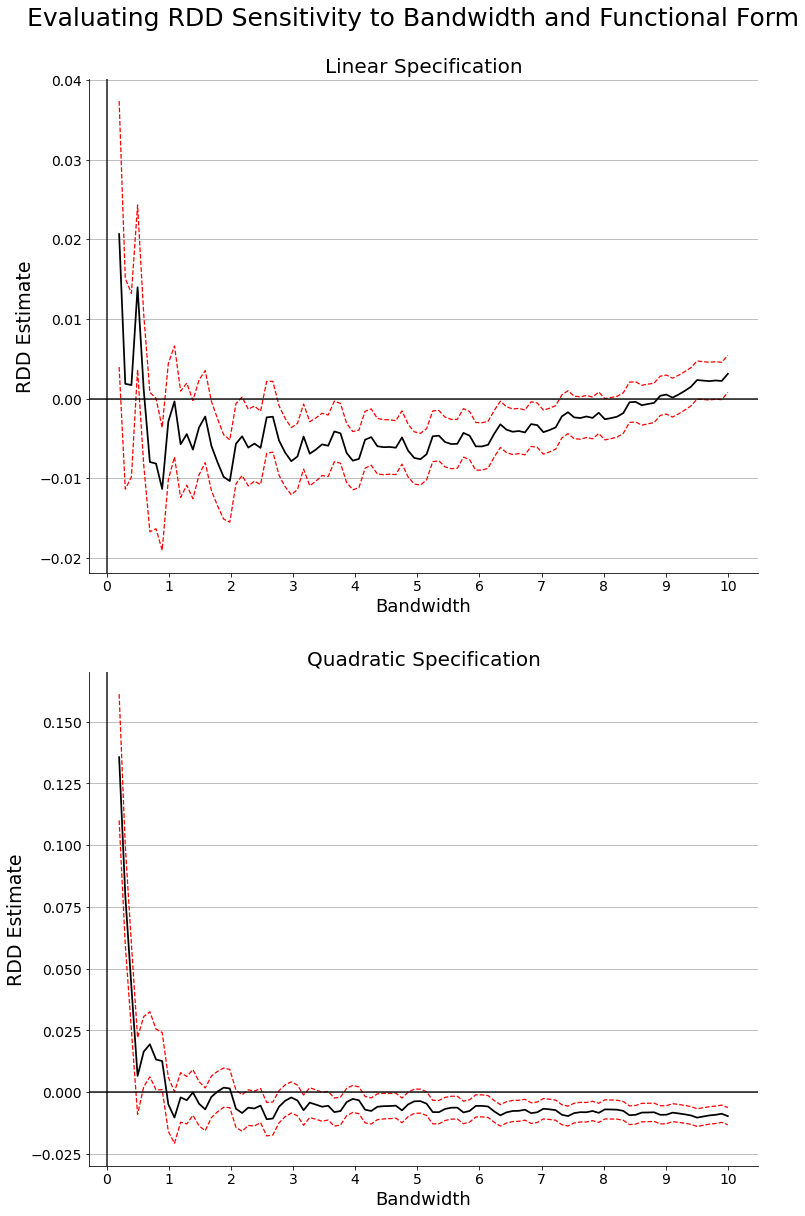

In [19]:
# Formatting stuff
fig,ax = plt.subplots(2, 1, figsize=(12,20))
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

# Do plotting
ax[0].plot(bandwidths, linear_betas, color='black', linewidth=1.75)
ax[0].plot(bandwidths, linear_beta_upper_CI, color='red', linestyle='dashed', linewidth=1.25)
ax[0].plot(bandwidths, linear_beta_lower_CI, color='red', linestyle='dashed', linewidth=1.25)
ax[0].axvline(x=0., color='black', alpha=0.9)
ax[0].axhline(y=0., color='black', alpha=0.9)

ax[1].plot(bandwidths, quadratic_betas, color='black', linewidth=1.75)
ax[1].plot(bandwidths, quadratic_beta_upper_CI, color='red', linestyle='dashed', linewidth=1.25)
ax[1].plot(bandwidths, quadratic_beta_lower_CI, color='red', linestyle='dashed', linewidth=1.25)
ax[1].axvline(x=0., color='black', alpha=0.9)
ax[1].axhline(y=0., color='black', alpha=0.9)

# Axis formatting
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[0].set_xticks(np.arange(0.,10.5,1.))
ax[1].set_xticks(np.arange(0.,10.5,1.))
ax[0].set_xlabel("Bandwidth", size=18)
ax[1].set_xlabel("Bandwidth", size=18)
ax[0].set_ylabel("RDD Estimate", size=19)
ax[1].set_ylabel("RDD Estimate", size=19)
ax[0].grid(axis='y')
ax[1].grid(axis='y')

# Deal with titles
ax[0].set_title(f"Linear Specification", size=20)
ax[1].set_title(f"Quadratic Specification", size=20)
plt.suptitle("Evaluating RDD Sensitivity to Bandwidth and Functional Form", size=25, y=0.93)

# Save and show
plt.savefig(f"./q5_output/q5_bandwidths.png")
plt.show()